

# Random Forest + Grid Search

In [1]:
import gc
import time
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

### Model training and hyperparameter tuning

In [5]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_labels = pd.read_csv("train_labels.csv")
test_labels = pd.read_csv("test_labels.csv")

In [6]:
train.shape, train_labels.shape

((783, 30), (783, 1))

In [16]:
test.shape, test_labels.shape

((196, 30), (196, 1))

In [9]:
train.columns #300 features selected, customer_ID and target

Index(['CoefficientVariationofStockPrice',
       'PercentageChangefromprevreportedEPS', 'PriceChange',
       'QuestionsSentiment', 'ConferenceSentiment', 'Has_QnA',
       'Reddit_Sentiment', 'RedditSD', 'TwitterSentiment', 'TwitterSD',
       'SocialMediaCovariance', 'TwitterSkew', 'TwitterKurtosis', 'RedditSkew',
       'RedditKurtosis', 'EPSEstimate', 'Has_Reddit', 'Communication Services',
       'Consumer Cyclical', 'Consumer Defensive', 'Energy',
       'Financial Services', 'Healthcare', 'Industrials', 'Real Estate',
       'Technology', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [10]:
test.columns #300 features selected, customer_ID

Index(['CoefficientVariationofStockPrice',
       'PercentageChangefromprevreportedEPS', 'PriceChange',
       'QuestionsSentiment', 'ConferenceSentiment', 'Has_QnA',
       'Reddit_Sentiment', 'RedditSD', 'TwitterSentiment', 'TwitterSD',
       'SocialMediaCovariance', 'TwitterSkew', 'TwitterKurtosis', 'RedditSkew',
       'RedditKurtosis', 'EPSEstimate', 'Has_Reddit', 'Communication Services',
       'Consumer Cyclical', 'Consumer Defensive', 'Energy',
       'Financial Services', 'Healthcare', 'Industrials', 'Real Estate',
       'Technology', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [11]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
smote = SMOTE(random_state = 1, sampling_strategy=1.0)
enn = EditedNearestNeighbours(n_neighbors=5, sampling_strategy = 'majority')

In [14]:
model_rf = Pipeline([('smt', smote),('enn', enn),('clf',RandomForestClassifier(criterion="gini",n_jobs=15,random_state=22))])

In [15]:
model_rf_without_balancing = Pipeline([('clf',RandomForestClassifier(criterion="gini",n_jobs=15,random_state=22))])

In [16]:
model_rf

Pipeline(steps=[('smt', SMOTE(random_state=1, sampling_strategy=1.0)),
                ('enn',
                 EditedNearestNeighbours(n_neighbors=5,
                                         sampling_strategy='majority')),
                ('clf', RandomForestClassifier(n_jobs=15, random_state=22))])

In [17]:
train.columns

Index(['CoefficientVariationofStockPrice',
       'PercentageChangefromprevreportedEPS', 'PriceChange',
       'QuestionsSentiment', 'ConferenceSentiment', 'Has_QnA',
       'Reddit_Sentiment', 'RedditSD', 'TwitterSentiment', 'TwitterSD',
       'SocialMediaCovariance', 'TwitterSkew', 'TwitterKurtosis', 'RedditSkew',
       'RedditKurtosis', 'EPSEstimate', 'Has_Reddit', 'Communication Services',
       'Consumer Cyclical', 'Consumer Defensive', 'Energy',
       'Financial Services', 'Healthcare', 'Industrials', 'Real Estate',
       'Technology', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [18]:
def param_grid_search(train, model, train_labels = train_labels):
    # Step 1.Generate a parameter space
    print('param_grid_search')
    features = train.columns.tolist() # Obtain all features
    
    # add more possible parameters and values
    # search google for a bigger parameter space
    n_estimators = [int(x) for x in np.linspace(start = 1, stop = 150, num = 20)] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node

    parameter_space = {
        "clf__n_estimators": n_estimators, 
        "clf__min_samples_leaf": min_samples_leaf ,
        "clf__min_samples_split": min_samples_split,
        "clf__max_depth": max_depth,
    }
    
    # Step 2.Tune Hyperparameters
    print("Tuning hyper-parameters for mse")
    grid = GridSearchCV(model, parameter_space, cv=10, scoring="accuracy",refit = True)
    print(train[features].shape, train_labels.shape)
    grid.fit(train[features].values, train_labels.values)
    
    # Step 3.Generate best parameters
    print("best_params_:")
    print(grid.best_params_)
    means = grid.cv_results_["mean_test_score"]
    stds = grid.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, grid.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    return grid

In [38]:
grid = param_grid_search(train, model = model_rf)

param_grid_search
Tuning hyper-parameters for mse
(783, 30) (783, 1)
best_params_:
{'clf__max_depth': 20, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 8}
0.658 (+/-0.097) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 1}
0.687 (+/-0.035) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 8}
0.687 (+/-0.057) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 16}
0.704 (+/-0.061) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 24}
0.693 (+/-0.062) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 32}
0.702 (+/-0.066) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 40}
0.700 (+/-0.063) for {'clf__max_depth': 10, 'clf__min_sampl

In [19]:
grid_without_balancing = param_grid_search(train, model = model_rf_without_balancing)

param_grid_search
Tuning hyper-parameters for mse
(783, 30) (783, 1)


C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

best_params_:
{'clf__max_depth': 20, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 55}
0.632 (+/-0.109) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 1}
0.665 (+/-0.084) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 8}
0.702 (+/-0.099) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 16}
0.706 (+/-0.105) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 24}
0.693 (+/-0.104) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 32}
0.699 (+/-0.092) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 40}
0.704 (+/-0.105) for {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 48}


0.712 (+/-0.094) for {'clf__max_depth': 120, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 87}
0.705 (+/-0.085) for {'clf__max_depth': 120, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 95}
0.704 (+/-0.088) for {'clf__max_depth': 120, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 102}
0.693 (+/-0.084) for {'clf__max_depth': 120, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 110}
0.696 (+/-0.082) for {'clf__max_depth': 120, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 118}
0.700 (+/-0.077) for {'clf__max_depth': 120, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 126}
0.700 (+/-0.083) for {'clf__max_depth': 120, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 134}
0.704 (+/-0.088) for {'clf__max_depth': 120, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 

In [20]:
grid_without_balancing.best_score_

0.7253489126906849

In [21]:
grid_without_balancing.best_estimator_

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=55,
                                        n_jobs=15, random_state=22))])

In [23]:
# Train score for accuracy, f1, roc_auc 
predictions_train = grid_without_balancing.best_estimator_.predict(train)
print(accuracy_score(train_labels, predictions_train))
print(roc_auc_score(train_labels, predictions_train))
print(f1_score(train_labels, predictions_train))

0.9272030651340997
0.8922905525846702
0.9484162895927601


In [25]:
# Test score for accuracy, f1, roc_auc 
predictions = grid_without_balancing.best_estimator_.predict(test)
print(accuracy_score(test_labels, predictions))
print(roc_auc_score(test_labels, predictions))
print(f1_score(test_labels, predictions))

0.7602040816326531
0.6811079545454546
0.8362369337979094


In [27]:
rf_pred = pd.DataFrame(predictions, columns = ['predictions'])

In [28]:
rf_pred.to_csv('model_rf_predictions.csv', index = False)

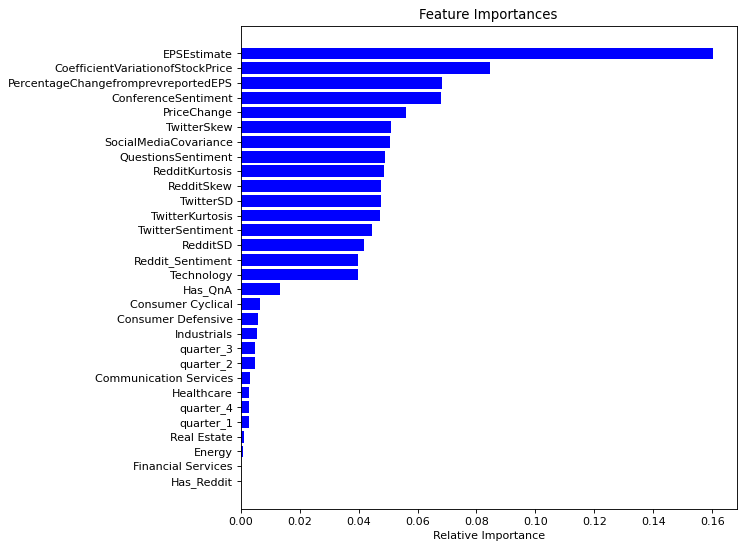

In [30]:
figure(figsize=(8, 8), dpi=80)
importances = grid_without_balancing.best_estimator_.named_steps["clf"].feature_importances_
indices = np.argsort(importances)
features = train.columns.tolist()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
